### Helper functions

In [9]:
import pandas as pd

def normalize_data(path: str, header: int = 10, nrows: int | None = None):
  df = pd.read_csv(path, header=header, index_col=0, nrows=nrows)
  df.columns = df.columns.astype(int).astype(str)
  for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
  return df

In [10]:
import statsmodels.api as sm
import pandas as pd
from typing import TypedDict

class LinearRegressionParameters(TypedDict):
  constant: float
  coefficient: float
  residuals: pd.Series

def time_series_linear_regression(
  target_values: pd.Series,
  independent_values: pd.Series
) -> LinearRegressionParameters:
  """
  Perform OLS regression for time series data.
  Model: target = constant + coefficient * independent + residual
  Args:
    target_values (pd.Series): dependent variable (e.g. ln(Y/K))
    independent_values (pd.Series): time variable or explanatory variable (e.g. year)
  Returns:
    dict: constant, coefficient, residuals
  """

  model = sm.OLS(
    target_values, 
    sm.add_constant(independent_values)
    ).fit()

  # 残差に時系列インデックスを保持
  residuals = model.resid
  residuals.index = target_values.index

  return {
    "constant": model.params["const"],
    "coefficient": model.params[independent_values.name],
    "residuals": residuals
  }


In [11]:
from statsmodels.tsa.filters.hp_filter import hpfilter
import pandas as pd
from typing import Literal

def hp_filter_trend(
    target_series: pd.Series,
    time_scale: Literal["yearly", "quarterly", "monthly"] = "yearly",
    with_cycle: bool | None = False
) -> pd.Series | tuple[pd.Series, pd.Series]:
    """
    Apply Hodrick-Prescott (HP) filter to extract the trend component
    from a time-series variable (e.g. productivity, utilization).
    Args:
        target_series (pd.Series): 時系列データ（インデックスは時系列）
        time_scale (str): "yearly", "quarterly", または "monthly"
    Returns:
        pd.Series: トレンド成分（trend component）
    """
    if time_scale == "yearly":
        lamb = 6.25
    elif time_scale == "quarterly":
        lamb = 1600
    elif time_scale == "monthly":
        lamb = 14400
    else:
        raise ValueError("time_scale must be 'yearly', 'quarterly', or 'monthly'.")

    cycle, trend = hpfilter(target_series, lamb=lamb)
    trend.index = target_series.index  # 元の時系列インデックスを保持
    if not with_cycle:
        return trend
    else:
        cycle.index = target_series.index 
        return cycle, trend
    


In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def calculate_capacity_utilization(Y: pd.Series, K: pd.Series):
  """"
    In(Y/K) = C + γt + ut \n
    ut' = hp(ut) \n
    St = exp(ut' - u‾)
  """
  target_value = np.log( Y / K ).dropna()
  target_value.name = "gdp per capital"
  independent_values = pd.Series(target_value.index.astype(int), index=target_value.index, name="year")
  capital_utilization_values_by_real_surplus = time_series_linear_regression(target_value, independent_values)['residuals']

  # HPフィルターで滑らかにする
  smoothed_capital_utilization_values_by_real_surplus = hp_filter_trend(
    capital_utilization_values_by_real_surplus, "yearly"
  )

  # 平均をゼロに揃えてから指数化（基準平均を1にする）
  smoothed_capital_utilization_values_by_real_surplus = smoothed_capital_utilization_values_by_real_surplus - smoothed_capital_utilization_values_by_real_surplus.mean()
  S_t = np.exp(smoothed_capital_utilization_values_by_real_surplus)
  S_t.name = "capacity_utilization_ratio"

  return S_t


### Growth Accounting

In [13]:
gdp = normalize_data("./data/singapore/sg_gdp_in_chained_by_industry.csv").iloc[0, :]
gdp = gdp["2024": "1990"].sort_index()


In [14]:
net_capital_stock = normalize_data("./data/singapore/sg_net_capital_stock.csv").loc["Total"]
net_capital_stock = net_capital_stock["2024": "1990"].sort_index()
capacity_utilization = calculate_capacity_utilization(gdp, net_capital_stock)

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [15]:
workers = normalize_data("./data/singapore/sg_labor_force.csv", header=9).drop("2025", axis=1).iloc[0, :] * 1000
workers = workers["2024": "1990"].sort_index()

hours = normalize_data("./data/singapore/sg_working_hours.csv").loc["Total"].sort_index()
smoothed_hours = hp_filter_trend(normalize_data("./data/singapore/sg_working_hours.csv").loc["Total"].sort_index(), "yearly")

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [16]:
income_share = normalize_data("./data/singapore/sg_income_share_of_gdp.csv", nrows=3)
labor_distribution = income_share.loc["Compensation Of Employees"] / (
  income_share.loc["Compensation Of Employees"] + 
  income_share.loc["Gross Operating Surplus"] + 
  income_share.loc["Taxes Less Subsidies On Production & On Imports"]
)
labor_distribution = labor_distribution["2024":"1990"].sort_index()


/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


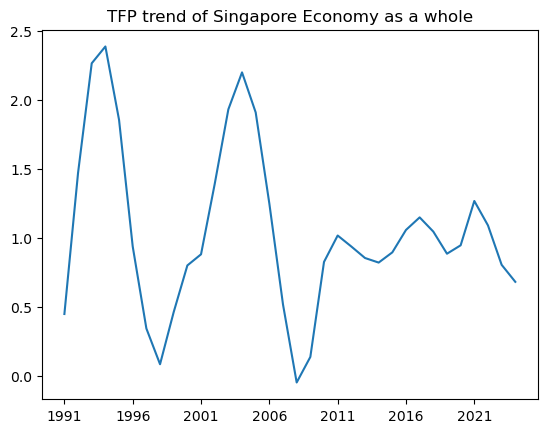

<Figure size 1000x600 with 0 Axes>

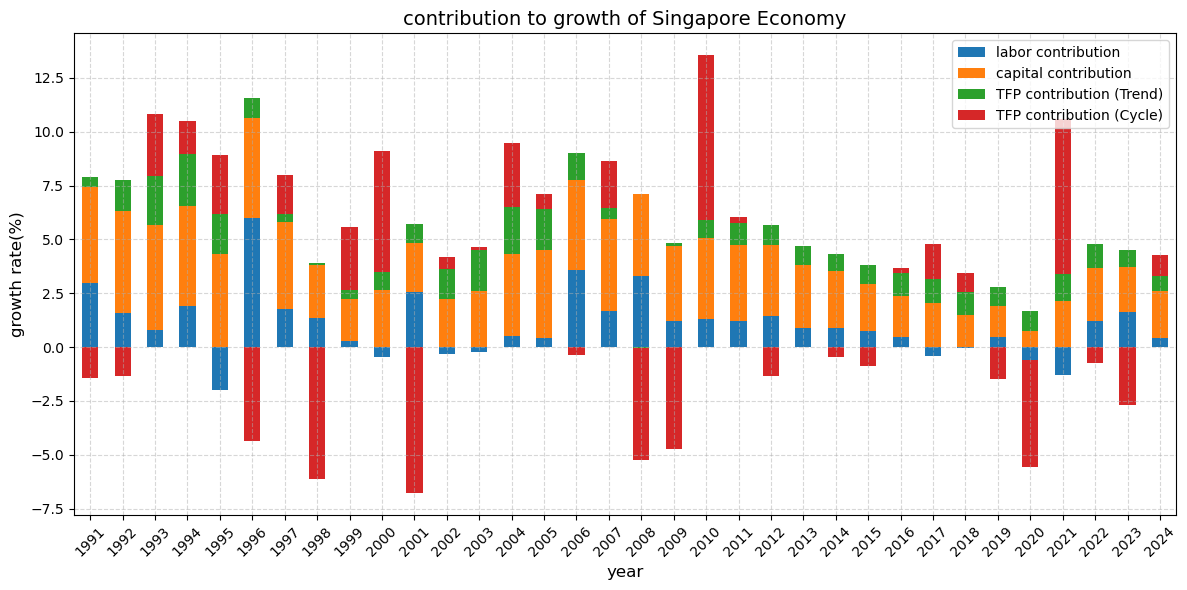

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def growth_accounting_calculator(Y, K, L, labor_share):
  gY = np.log(Y).diff().dropna()
  gK = np.log(K).diff().dropna()
  gL = np.log(L).diff().dropna()

  alpha = 1 - labor_share.loc[gL.index]  
  gA = gY - ((1 - alpha) * gL + alpha * gK)
  cycle, trend = hp_filter_trend(gA, "yearly", True)

  # 成長寄与度を計算（単位：%）
  labor_contrib = (1 - alpha) * gL * 100
  capital_contrib = alpha * gK * 100

  # データをまとめる
  df = pd.DataFrame({
    'labor contribution': labor_contrib,
    'capital contribution': capital_contrib,
    'TFP contribution (Trend)': trend * 100,
    'TFP contribution (Cycle)': cycle * 100
  }, index=Y.index).dropna()
  return df

def plotter(df: pd.DataFrame):
  # プロット
  plt.figure(figsize=(10,6))
  df.plot(kind='bar', stacked=True, figsize=(12,6))

  plt.title("contribution to growth of Singapore Economy", fontsize=14)
  plt.xlabel("year", fontsize=12)
  plt.ylabel("growth rate(%)", fontsize=12)
  plt.xticks(rotation=45)
  plt.legend(loc='best')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

df = growth_accounting_calculator(gdp, net_capital_stock * capacity_utilization, workers * smoothed_hours, labor_distribution)

df["TFP contribution (Trend)"].plot(title="TFP trend of Singapore Economy as a whole")
plotter(df)
